# Implementation of the "Histogram of Oriented Gradients" method for the MVA Kernel course Kaggle challenge

## Download packages

In [1]:
%pylab inline
import pandas
import cvxopt
import time
import numpy as np
import numpy.linalg as la
import scipy
from scipy.stats import mode
import matplotlib.pyplot as plt 
from numpy import arctan2, fliplr, flipud

## Import data

In [9]:
X_train = np.genfromtxt('/Users/badr-eddinecherief-abdellatif/Documents/ENSAE/3A/MVA/Kernel methods/Projet ENS/Bases/Xtr.csv',delimiter=',')[:,0:3072]
Y_train = np.genfromtxt('/Users/badr-eddinecherief-abdellatif/Documents/ENSAE/3A/MVA/Kernel methods/Projet ENS/Bases/Ytr.csv',delimiter=';')[1:5001,1]
X_test = np.genfromtxt('/Users/badr-eddinecherief-abdellatif/Documents/ENSAE/3A/MVA/Kernel methods/Projet ENS/Bases/Xte.csv',delimiter=',')[:,0:3072]

## Step 1 : Compute discret gradients

In [29]:
def gradient(image, same_size):
    """ Computes the Gradients of the image separated pixel difference
    
    Gradient of X is computed using the filter 
        [-1, 0, 1]
    Gradient of Y is computed using the filter 
        [[1,
          0,
          -1]]
    Parameters
    ----------
    image: image of shape (imy, imx)
    same_size: boolean, optional, default is True
        If True, boundaries are duplicated so that the gradients
        has the same size as the original image.
        Otherwise, the gradients will have shape (imy-2, imx-2)
        
    Returns
    -------
    (Gradient X, Gradient Y), two numpy array with the same shape as image
        (if same_size=True)
    """
    same_size=False
    sy, sx = image.shape
    if same_size:
        gx = np.zeros(image.shape)
        gx[:, 1:-1] = -image[:, :-2] + image[:, 2:]
        gx[:, 0] = -image[:, 0] + image[:, 1]
        gx[:, -1] = -image[:, -2] + image[:, -1]
    
        gy = np.zeros(image.shape)
        gy[1:-1, :] = image[:-2, :] - image[2:, :]
        gy[0, :] = image[0, :] - image[1, :]
        gy[-1, :] = image[-2, :] - image[-1, :]
    
    else:
        gx = np.zeros((sy-2, sx-2))
        gx[:, :] = -image[1:-1, :-2] + image[1:-1, 2:]

        gy = np.zeros((sy-2, sx-2))
        gy[:, :] = image[:-2, 1:-1] - image[2:, 1:-1]
    
    return gx, gy

In [30]:
def magnitude_orientation(gx, gy):
    """ Computes the magnitude and orientation matrices from the gradients gx gy
    Parameters
    ----------
    gx: gradient following the x axis of the image
    gy: gradient following the y axis of the image
    
    Returns 
    -------
    (magnitude, orientation)
    
    Warning
    -------
    The orientation is in degree, NOT radian!!
    """
        
    magnitude = np.sqrt(gx**2 + gy**2)
    orientation = (arctan2(gy, gx) * 180 / np.pi) % 360
            
    return magnitude, orientation

## Step 2 : Compute HoG in (csx,csy) cells (with normalization across blocks)

In [33]:
def compute_coefs(csx, csy, dx, dy, n_cells_x, n_cells_y):
    """
    Computes the coefficients for the bilinear (spatial) interpolation
    
    Parameters
    ----------
    csx: int
        number of columns of the cells
    csy: int
        number of raws dimension of the cells
    sx: int
        number of colums of the image (x axis)
    sy: int
        number of raws of the image (y axis)
    n_cells_x: int
        number of cells in the x axis
    n_cells_y: int
        number of cells in the y axis
    
    Notes
    -----
    We consider an image: image[y, x] (NOT image[x, y]!!!)
    
    /!\ csx and csy must be even number
    
    Using the coefficients
    ----------------------
    The coefficient correspond to the interpolation in direction of the upper left corner of the image.
    In other words, if you interpolate img, and res is the result of your interpolation, you should do
    
    res = zeros(n_cells_y*pixels_per_cell, n_cells_x*pixels_per_cell)
        with (csx, csy) the number of pixels per cell
         and dx, dy = csx//2, csy//2
    res[:-dx, :-dy] += img[dx:, dy:]*coefs
    
    then you rotate the coefs and do the same thing for every part of the image
    """
    if csx != csy:
        raise NotImplementedError("For now compute_coefs is only implemented for squared cells (csx == csy)")
        
        ################################
        #####     /!\ TODO  /!\    #####
        ################################

    else: # Squared cells
        # Note: in this case, dx = dy, we differentiate them only to make the code clearer
        
        # We want a squared coefficients matrix so that it can be rotated to interpolate in every direction
        n_cells = max(n_cells_x, n_cells_y)
        
        # Every cell of this matrix corresponds to (x - x_1)/dx 
        x = (np.arange(dx)+0.5)/csx
        
        # Every cell of this matrix corresponds to (y - y_1)/dy
        y = (np.arange(dy)+0.5)/csy
        
        y = y[np.newaxis, :]
        x = x[:, np.newaxis]

        # CENTRAL COEFFICIENT
        ccoefs = np.zeros((csy, csx))

        ccoefs[:dy, :dx] = (1 - x)*(1 - y)
        ccoefs[:dy, -dx:] = fliplr(y)*(1 - x)
        ccoefs[-dy:, :dx] = (1 - y)*flipud(x)
        ccoefs[-dy:, -dx:] = fliplr(y)*flipud(x)

        coefs = np.zeros((csx*n_cells - dx, csy*n_cells - dy))
        coefs[:-dy, :-dx] = np.tile(ccoefs, (n_cells - 1, n_cells - 1))

        # REST OF THE BORDER
        coefs[:-dy, -dx:] = np.tile(np.concatenate(((1 - x), np.flipud(x))), (n_cells - 1, dy))
        coefs[-dy:, :-dx] = np.tile(np.concatenate(((1 - y), np.fliplr(y)), axis=1), (dx, n_cells - 1))
        coefs[-dy:, -dx:] = 1

        return coefs

In [34]:
def interpolate_orientation(orientation, sx, sy, nbins, signed_orientation):
    """ interpolates linearly the orientations to their corresponding bins
    Parameters
    ----------
    sx: int
        number of columns of the image (x axis)
    sy: int
        number of raws of the image (y axis)
    nbins : int, optional, default is 9
        Number of orientation bins.
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            ie orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    Returns
    -------
    pre-histogram: array of shape (sx, sy, nbins)
            contains the pre histogram of orientation built using linear interpolation
            to interpolate the orientations to their bins
    """
    
    if signed_orientation:
        max_angle = 360
    else:
        max_angle = 180
    
    b_step = max_angle/nbins
    b0 = (orientation % max_angle) // b_step
    b0[np.where(b0>=nbins)]=0
    b1 = b0 + 1
    b1[np.where(b1>=nbins)]=0
    b = np.abs(orientation % b_step) / b_step
    
    #linear interpolation between the bins
    # Coefficients corresponding to the bin interpolation
    # We go from an image to a higher dimension representation of size (sizex, sizey, nbins)
    temp_coefs = np.zeros((sy, sx, nbins))
    for i in range(nbins):
        temp_coefs[:, :, i] += np.where(b0==i, (1 - b), 0)
        temp_coefs[:, :, i] += np.where(b1==i, b, 0)
    
    return temp_coefs

In [40]:
def per_pixel_hog(image, dy, dx, signed_orientation, nbins, flatten, normalise):
    """ builds a histogram of orientation for a cell centered around each pixel of the image
    
    Parameters
    ---------
    image: numpy array of shape (sizey, sizex)
    dx   : the cell around each pixel in the x axis will have size 2*dx+1
    dy   : the cell around each pixel in the y axis will have size 2*dy+1
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            i.e. orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    nbins : int, optional, default is 9
        Number of orientation bins.
        
    Returns
    -------
    if visualise if True: (histogram of oriented gradient, visualisation image)
    
    histogram of oriented gradient:
        numpy array of shape (n_cells_y, n_cells_x, nbins), flattened if flatten is True
    """
    dy=2
    dx=2
    signed_orientation=False
    nbins=9
    flatten=False
    normalise=True
    gx, gy = gradient(image, same_size=True)
    magnitude, orientation = magnitude_orientation(gx, gy)
    sy, sx = image.shape
    orientations_image = interpolate_orientation(orientation, sx, sy, nbins, signed_orientation)
    for j in range(1, dy):
        for i in range(1, dx):
            orientations_image[:-j, :-i, :] += orientations_image[j:, i:, :]
    
    if normalise:
        normalised_blocks = normalise_histogram(orientations_image, 1, 1, 1, 1, nbins)
    else:
        normalised_blocks = orientations_image
    
    if flatten:
        normalised_blocks = normalised_blocks.flatten()

    return normalised_blocks

In [55]:
def interpolate(magnitude, orientation, csx, csy, sx, sy, n_cells_x, n_cells_y, signed_orientation, nbins):
    """ Returns a matrix of size (cell_size_x, cell_size_y, nbins) corresponding
         to the trilinear interpolation of the pixels magnitude and orientation
    Parameters
    ----------
    csx: int
        number of columns of the cells
    csy: int
        number of raws dimension of the cells
    sx: int
        number of colums of the image (x axis)
    sy: int
        number of raws of the image (y axis)
    n_cells_x: int
        number of cells in the x axis
    n_cells_y: int
        number of cells in the y axis
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            ie orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    nbins : int, optional, default is 9
        Number of orientation bins.
    Returns
    -------
    orientation_histogram: array of shape (n_cells_x, n_cells_y, nbins)
            contains the histogram of orientation built using tri-linear interpolation
    """
    signed_orientation=False
    nbins=9
    
    dx = csx//2
    dy = csy//2
    
    temp_coefs = interpolate_orientation(orientation, sx, sy, nbins, signed_orientation)


    # Coefficients of the spatial interpolation in every direction
    coefs = compute_coefs(csx, csy, dx, dy, n_cells_x, n_cells_y)
    
    temp = np.zeros((sy, sx, nbins))
    # hist(y0, x0)
    temp[:-dy, :-dx, :] += temp_coefs[dy:, dx:, :]*\
        (magnitude[dy:, dx:]*coefs[-(n_cells_y*csy - dy):, -(n_cells_x*csx - dx):])[:, :, np.newaxis]
    
    # hist(y1, x0)
    coefs = np.rot90(coefs)
    temp[dy:, :-dx, :] += temp_coefs[:-dy, dx:, :]*\
        (magnitude[:-dy, dx:]*coefs[:(n_cells_y*csy - dy), -(n_cells_x*csx - dx):])[:, :, np.newaxis]
    
    # hist(y1, x1)
    coefs = np.rot90(coefs)
    temp[dy:, dx:, :] += temp_coefs[:-dy, :-dx, :]*\
        (magnitude[:-dy, :-dx]*coefs[:(n_cells_y*csy - dy), :(n_cells_x*csx - dx)])[:, :, np.newaxis]
    
    # hist(y0, x1)
    coefs = np.rot90(coefs)
    temp[:-dy, dx:, :] += temp_coefs[dy:, :-dx, :]*\
        (magnitude[dy:, :-dx]*coefs[-(n_cells_y*csy - dy):, :(n_cells_x*csx - dx)])[:, :, np.newaxis]
    
    # Compute the histogram: sum over the cells
    orientation_histogram = temp.reshape((n_cells_y, csy, n_cells_x, csx, nbins)).sum(axis=3).sum(axis=1)
    
    return orientation_histogram

In [56]:
def draw_histogram(hist, csx, csy, signed_orientation):
    """ simple function to draw an orientation histogram
        with arrows
    """
    signed_orientation=False
    
    if signed_orientation:
        max_angle = 2*np.pi
    else:
        max_angle = np.pi
    
    n_cells_y, n_cells_x, nbins = hist.shape
    sx, sy = n_cells_x*csx, n_cells_y*csy
    plt.close()
    plt.figure()#figsize=(sx/2, sy/2))#, dpi=1)
    plt.xlim(0, sx)
    plt.ylim(sy, 0)
    center = csx//2, csy//2
    b_step = max_angle / nbins
        
    for i in range(n_cells_y):
        for j in range(n_cells_x):
            for k in range(nbins):
                if hist[i, j, k] != 0:
                    width = 1*hist[i, j, k]
                    plt.arrow((center[0] + j*csx) - np.cos(b_step*k)*(center[0] - 1),
                              (center[1] + i*csy) + np.sin(b_step*k)*(center[1] - 1), 
                          2*np.cos(b_step*k)*(center[0] - 1), -2*np.sin(b_step*k)*(center[1] - 1),
                          width=width, color=str(width), #'black',
                          head_width=2.2*width, head_length=2.2*width,
                          length_includes_head=True)
                    
    plt.show()

In [59]:
def visualise_histogram(hist, csx, csy, signed_orientation):
    """ Create an image visualisation of the histogram of oriented gradient
    
    Parameters
    ----------
    hist: numpy array of shape (n_cells_y, n_cells_x, nbins)
        histogram of oriented gradient
    csx: int
        number of columns of the cells
    csy: int
        number of raws dimension of the cells
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            ie orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    
    Return
    ------
    Image of shape (hist.shape[0]*csy, hist.shape[1]*csx)
    """
    from skimage import draw  
    """ we just need the function "draw.line" from skimage
    """
    
    signed_orientation=False
    
    if signed_orientation:
        max_angle = 2*np.pi
    else:
        max_angle = np.pi
    
    n_cells_y, n_cells_x, nbins = hist.shape
    sx, sy = n_cells_x*csx, n_cells_y*csy
    center = csx//2, csy//2
    b_step = max_angle / nbins

    radius = min(csx, csy) // 2 - 1
    hog_image = np.zeros((sy, sx), dtype=float)
    for x in range(n_cells_x):
        for y in range(n_cells_y):
            for o in range(nbins):
                centre = tuple([y * csy + csy // 2, x * csx + csx // 2])
                dx = radius * np.cos(o*nbins)
                dy = radius * np.sin(o*nbins)
                rr, cc = draw.line(int(centre[0] - dy),
                                   int(centre[1] - dx),
                                   int(centre[0] + dy),
                                   int(centre[1] + dx))
                hog_image[rr, cc] += hist[y, x, o]
    return hog_image

In [60]:
def normalise_histogram(orientation_histogram, bx, by, n_cells_x, n_cells_y, nbins):
    """ normalises a histogram by blocks
    
    Parameters
    ----------
    bx: int
        number of blocks on the x axis
    by: int
        number of blocks on the y axis
    n_cells_x: int
        number of cells in the x axis
    n_cells_y: int
        number of cells in the y axis
    nbins : int, optional, default is 9
        Number of orientation bins.
     
    The normalisation is done according to Dalal's original thesis, using L2-Hys.
    In other words the histogram is first normalised block-wise using l2 norm, before clipping it by
        limiting the values between 0 and 0.02 and finally normalising again with l2 norm
    """
    eps = 1e-7
    
    if bx==1 and by==1: 
        normalised_blocks = np.clip(
          orientation_histogram / np.sqrt(orientation_histogram.sum(axis=-1)**2 + eps)[:, :, np.newaxis], 0, 0.2)
        normalised_blocks /= np.sqrt(normalised_blocks.sum(axis=-1)**2 + eps)[:, :, np.newaxis]
        
    else:
        n_blocksx = (n_cells_x - bx) + 1
        n_blocksy = (n_cells_y - by) + 1
        normalised_blocks = np.zeros((n_blocksy, n_blocksx, nbins))

        for x in range(n_blocksy):
            for y in range(n_blocksx):
                block = orientation_histogram[y:y + by, x:x + bx, :]
                normalised_blocks[y, x, :] = np.clip(block[0, 0, :] / np.sqrt(block.sum()**2 + eps), 0, 0.2)
                normalised_blocks[y, x, :] /= np.sqrt(normalised_blocks[y, x, :].sum()**2 + eps)

    return normalised_blocks

In [61]:
def build_histogram(magnitude, orientation, cell_size, signed_orientation,
         nbins, cells_per_block, visualise, flatten, normalise):
    """ builds a histogram of orientation using the provided magnitude and orientation matrices
    
    Parameters
    ---------
    magnitude: np-array of size (sy, sx)
        matrix of magnitude
    orientation: np-array of size (sy, sx)
        matrix of orientations
    csx: int
        number of columns of the cells 
        MUST BE EVEN
    csy: int
        number of raws dimension of the cells
        MUST BE EVEN
    sx: int
        number of colums of the image (x axis)
    sy: int
        number of raws of the image (y axis)
    n_cells_x: int
        number of cells in the x axis
    n_cells_y: int
        number of cells in the y axis
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            ie orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    nbins : int, optional, default is 9
        Number of orientation bins.
        
    Returns
    -------
    if visualise if True: (histogram of oriented gradient, visualisation image)
    
    histogram of oriented gradient:
        numpy array of shape (n_cells_y, n_cells_x, nbins), flattened if flatten is True
    visualisation image:
        Image of shape (hist.shape[0]*csy, hist.shape[1]*csx)
    """
    cell_size=(8, 8)
    signed_orientation=False
    nbins=9
    cells_per_block=(1, 1) 
    visualise=False
    flatten=False
    normalise=True
        
    sy, sx = magnitude.shape
    csy, csx = cell_size
    
    # checking that the cell size are even
    if csx % 2 != 0:
        csx += 1
        print("WARNING: the cell_size must be even, incrementing cell_size_x of 1")
    if csy % 2 != 0:
        csy += 1
        print("WARNING: the cell_size must be even, incrementing cell_size_y of 1")
    
    # Consider only the right part of the image
    # (if the rest doesn't fill a whole cell, just drop it)
    sx -= sx % csx
    sy -= sy % csy
    n_cells_x = sx//csx
    n_cells_y = sy//csy
    magnitude = magnitude[:sy, :sx]
    orientation = orientation[:sy, :sx]
    by, bx = cells_per_block
    
    orientation_histogram = interpolate(magnitude, orientation, csx, csy, sx, sy, n_cells_x, n_cells_y, signed_orientation, nbins)
    
    if normalise:
        normalised_blocks = normalise_histogram(orientation_histogram, bx, by, n_cells_x, n_cells_y, nbins)
    else:
        normalised_blocks = orientation_histogram
    
    if flatten:
        normalised_blocks = normalised_blocks.flatten()

    if visualise:
        #draw_histogram(normalised_blocks, csx, csy, signed_orientation)
        return normalised_blocks, visualise_histogram(normalised_blocks, csx, csy, signed_orientation)
    else:
        return normalised_blocks

In [62]:
def histogram_from_gradients(gradientx, gradienty, cell_size, cells_per_block, signed_orientation,
        nbins, visualise, normalise, flatten, same_size):
    """ builds a histogram of oriented gradient from the provided gradients
    Parameters
    ----------
    gradientx : (M, N) ndarray
        Gradient following the x axis
    gradienty: (M, N) ndarray
        Gradient following the y axis
    nbins : int, optional
        Number of orientation bins.
    cell_size : 2 tuple (int, int)
        Size (in pixels) of a cell.
    cells_per_block : 2 tuple (int,int)
        Number of cells in each block.
    visualise : bool, optional, default is False
        Also return an image of the HOG.
    flatten: bool, optional, default is True
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            ie orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    normalise: bool, optional, default is True
        if True, the histogram is normalised block-wise
    same_size: bool, optional, default is False
        if True, the boundaries are duplicated when computing the gradients of the image
        so that these have the same size as the original image
    Returns
    -------
    if visualise if True: (histogram of oriented gradient, visualisation image)
    
    histogram of oriented gradient:
        numpy array of shape (n_cells_y, n_cells_x, nbins), flattened if flatten is True
    visualisation image:
        Image of shape (hist.shape[0]*csy, hist.shape[1]*csx)
    References
    ----------
    * http://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    * Dalal, N and Triggs, B, Histograms of Oriented Gradients for
    Human Detection, IEEE Computer Society Conference on Computer
    Vision and Pattern Recognition 2005 San Diego, CA, USA
    """
    cell_size=(8, 8)
    cells_per_block=(1, 1)
    signed_orientation=False
    nbins=9
    visualise=False
    normalise=True
    flatten=False
    same_size=False
    
    magnitude, orientation = magnitude_orientation(gradientx, gradienty)
    return build_histogram(magnitude, orientation, cell_size=cell_size,
         signed_orientation=signed_orientation, cells_per_block=cells_per_block,
         nbins=nbins, visualise=visualise, normalise=normalise, flatten=flatten)

## Step 3 : Compute HoG feature vectors

In [63]:
def hog(image, cell_size, cells_per_block, signed_orientation,
        nbins, visualise, normalise, flatten, same_size):
    """ builds a histogram of oriented gradient (HoG) from the provided image
    Compute a Histogram of Oriented Gradients (HOG) by
    1. computing the gradient image in x and y and deduce from them the magnitude and orientation
        of each pixel
    2. computing gradient histograms (vectorised version)
    3. normalising across blocks
    4. flattening into a feature vector if flatten=True
    Parameters
    ----------
    image : (M, N) ndarray
        Input image (greyscale).
    nbins : int, optional, default is 9
        Number of orientation bins.
    cell_size : 2 tuple (int, int)
        Size (in pixels) of a cell.
    cells_per_block : 2 tuple (int,int)
        Number of cells in each block.
    visualise : bool
        Also return an image of the HOG.
    flatten: bool
    signed_orientation: bool, default is True
        if True, sign information of the orientation is preserved,
            ie orientation angles are between 0 and 360 degree.
        if False, the angles are between 0 and 180 degree.
    normalise: bool
        if True, the histogram is normalised block-wise
    same_size: bool
        if True, the boundaries are duplicated when computing the gradients of the image
        so that these have the same size as the original image
    Returns
    -------
    if visualise if True: (histogram of oriented gradient, visualisation image)
    
    histogram of oriented gradient:
        numpy array of shape (n_cells_y, n_cells_x, nbins), flattened if flatten is True
    visualisation image:
        Image of shape (hist.shape[0]*csy, hist.shape[1]*csx)
    References
    ----------
    * http://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    * Dalal, N and Triggs, B, Histograms of Oriented Gradients for
    Human Detection, IEEE Computer Society Conference on Computer
    Vision and Pattern Recognition 2005 San Diego, CA, USA
    """
    cell_size=(4, 4)
    cells_per_block=(1, 1)
    signed_orientation=False
    nbins=9
    visualise=False
    normalise=True
    flatten=False 
    same_size=True
        
    gx, gy = gradient(image, same_size=same_size)
    return histogram_from_gradients(gx, gy, cell_size=cell_size,
         signed_orientation=signed_orientation, cells_per_block=cells_per_block,
         nbins=nbins, visualise=visualise, normalise=normalise, flatten=flatten,same_size=same_size)

## Test on a simple example

In [70]:
def octagon():
    return np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                     [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                     [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                     [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                     [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                     [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                     [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
                     [0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
                     [0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])   

In [71]:
img = octagon()
gx, gy = gradient(img, same_size=False)
mag, ori = magnitude_orientation(gx, gy)

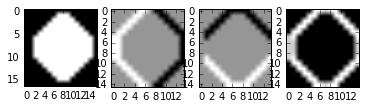

In [72]:
# Show gradient and magnitude
plt.figure()
plt.title('gradients and magnitude')
plt.subplot(141)
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.subplot(142)
plt.imshow(gx, cmap=plt.cm.Greys_r)
plt.subplot(143)
plt.imshow(gy, cmap=plt.cm.Greys_r)
plt.subplot(144)
plt.imshow(mag, cmap=plt.cm.Greys_r)

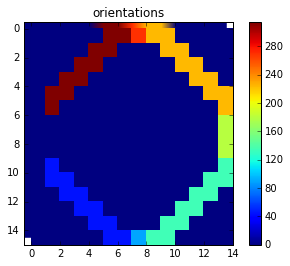

In [73]:
# Show the orientation deducted from gradient
plt.figure()
plt.title('orientations')
plt.imshow(ori)
plt.pcolor(ori)
plt.colorbar()

In [126]:
# Plot histogram 
from scipy.ndimage.interpolation import zoom
# make the image bigger to compute the histogram
im1 = zoom(octagon(), 3)
h = hog(im1, cell_size=(2, 2), cells_per_block=(1, 1), visualise=False, nbins=9, signed_orientation=False, normalise=True, flatten=False, same_size=True)
im2 = visualise_histogram(h, 8, 8, False)

In [128]:
im2.shape

(48, 40)

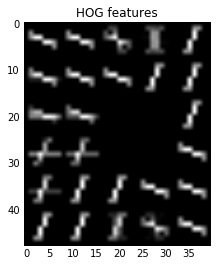

In [127]:
plt.figure()
plt.title('HOG features')
plt.imshow(im2, cmap=plt.cm.Greys_r)

## Test on one of our images

In [115]:
X_train[9][0:1024].reshape(32,32)

array([[-0.00762504,  0.01693876, -0.00425453, ..., -0.05997973,
        -0.01986801, -0.05011008],
       [-0.03959351, -0.05987313,  0.0087661 , ..., -0.03769633,
         0.08951911,  0.04178096],
       [-0.03656383, -0.0721495 ,  0.04580768, ..., -0.06117816,
         0.06985157,  0.02472135],
       ..., 
       [-0.03312601, -0.03059224, -0.01676401, ..., -0.00964776,
        -0.02648002,  0.0323438 ],
       [ 0.00832087,  0.00626354,  0.01300299, ..., -0.0130065 ,
         0.01989042,  0.121176  ],
       [-0.00728178, -0.00137382, -0.00239082, ..., -0.00761034,
         0.0611766 ,  0.09727795]])

In [116]:
img = X_train[9][0:1024].reshape(32,32)
gx, gy = gradient(img, same_size=False)
mag, ori = magnitude_orientation(gx, gy)

Temps : 0.1895590000001448


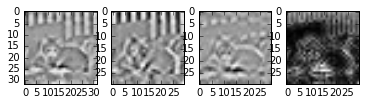

In [117]:
# Show gradient and magnitude
s1=time.clock()
plt.figure()
plt.title('gradients and magnitude')
plt.subplot(141)
plt.imshow(img, cmap=plt.cm.Greys_r)
plt.subplot(142)
plt.imshow(gx, cmap=plt.cm.Greys_r)
plt.subplot(143)
plt.imshow(gy, cmap=plt.cm.Greys_r)
plt.subplot(144)
plt.imshow(mag, cmap=plt.cm.Greys_r)
s2=time.clock()
print("Temps :",s2-s1)

Temps : 0.1154399999998077


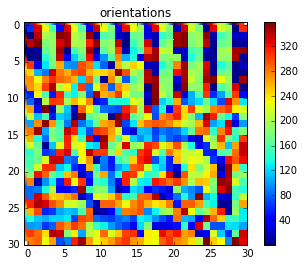

In [118]:
# Show the orientation deducted from gradient
s1=time.clock()
plt.figure()
plt.title('orientations')
plt.imshow(ori)
plt.pcolor(ori)
plt.colorbar()
s2=time.clock()
print("Temps :",s2-s1)

In [119]:
# Plot histogram 
from scipy.ndimage.interpolation import zoom
# make the image bigger to compute the histogram
s1=time.clock()
im1 = zoom(X_train[9][0:1024].reshape(32,32), 3)
h = hog(im1, cell_size=(2, 2), cells_per_block=(1, 1), visualise=False, nbins=9, signed_orientation=False, normalise=True, flatten=False, same_size=True)
im2 = visualise_histogram(h, 8, 8, False)
s2=time.clock()
print("Temps :",s2-s1)

Temps : 0.12871199999995042


In [124]:
im2.shape

(88, 88)

Temps : 0.04760800000008203


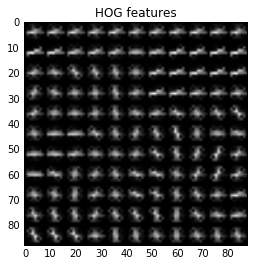

In [120]:
s1=time.clock()
plt.figure()
plt.title('HOG features')
plt.imshow(im2, cmap=plt.cm.Greys_r)
s2=time.clock()
print("Temps :",s2-s1)

## Transform our whole database

In [108]:
imgint = X_train[9][0:1024].reshape(32,32)
gxint, gyint = gradient(imgint, same_size=False)
magint, oriint = magnitude_orientation(gxint, gyint)
im1int = zoom(X_train[9][0:1024].reshape(32,32), 3)
hint = hog(im1int, cell_size=(2, 2), cells_per_block=(1, 1), visualise=False, nbins=9, signed_orientation=False, normalise=True, flatten=False, same_size=True)
im2int = visualise_histogram(hint, 8, 8, False)
img = 5000*[imgint]
gx = 5000*[gxint]
gy = 5000*[gyint]
mag = 5000*[magint]
ori = 5000*[oriint] 
im1 = 5000*[im1int]
h = 5000*[hint]
im2 = 5000*[im2int]

In [109]:
for i in range(len(img)) :
    img[i] = X_train[i][0:1024].reshape(32,32)
    gx[i], gy[i] = gradient(img[i], same_size=False)
    mag[i], ori[i] = magnitude_orientation(gx[i], gy[i])

In [110]:
# Plot histogram 
from scipy.ndimage.interpolation import zoom
# make the image bigger to compute the histogram
s1=time.clock()
for i in range(len(img)) :
    im1[i] = zoom(X_train[i][0:1024].reshape(32,32), 3)
    h[i] = hog(im1[i], cell_size=(2, 2), cells_per_block=(1, 1), visualise=False, nbins=9, signed_orientation=False, normalise=True, flatten=False, same_size=True)
    im2[i] = visualise_histogram(h[i], 8, 8, False)
s2=time.clock()
print("Temps :",s2-s1)

Temps : 150.34039000000007
